In [32]:
import pandas as pd
import zipfile
import os
from google.colab import drive
drive.mount('/content/MyDrive/')

directory_path = '/content/MyDrive/MyDrive/City of Boston: Transit & Performance A/Data Files/MBTA_Bus_Arrival_Departure_Times_2022'
files = os.listdir(directory_path)


Drive already mounted at /content/MyDrive/; to attempt to forcibly remount, call drive.mount("/content/MyDrive/", force_remount=True).


In [33]:
jan_data = pd.read_csv(os.path.join(directory_path, 'MBTA-Bus-Arrival-Departure-Times_2022-01.csv'))

In [34]:
# Keeping only the specified columns
jan_data = jan_data[['service_date', 'half_trip_id', 'route_id', 'direction_id', 'point_type', 'scheduled', 'actual']]
# Filtering out rows where point_type is 'Midpoint'
jan_data = jan_data.loc[jan_data['point_type'] != 'Midpoint']
jan_data = jan_data.sort_values(by=['route_id','service_date','half_trip_id'])

In [35]:
import numpy as np

def time_diff(data):
    convert(data)

    # Calculate min and max in one go to reduce the number of groupby operations
    aggs = data.groupby(['route_id', 'direction_id', 'half_trip_id'])['actual'].agg(['min', 'max'])

    # Calculate time difference and convert to minutes
    time_diffs = (aggs['max'] - aggs['min']).dt.total_seconds() / 60
    # Filter out routes with 0 travel time
    non_zero_time_diffs = time_diffs[time_diffs > 0]
    # Calculate average time difference for each route and direction
    average_time_diffs = time_diffs.groupby(level=['route_id', 'direction_id']).mean().reset_index()
    average_time_diffs.columns = ['route_id', 'direction_id', 'average_time_diff']

    return average_time_diffs, time_diffs

def convert(data):
    data['scheduled'] = pd.to_datetime(data['scheduled'], errors='coerce', utc=True)
    data['actual'] = pd.to_datetime(data['actual'], errors='coerce', utc=True)

In [36]:
# Calculate time difference
jan_avg, jan_diffs  = time_diff(jan_data)

<ipython-input-37-9cb5abcc4400>:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  bar_plot = sns.barplot(x='route_id', y='average_time_diff', hue='direction_id', data=jan_avg, ci=None)


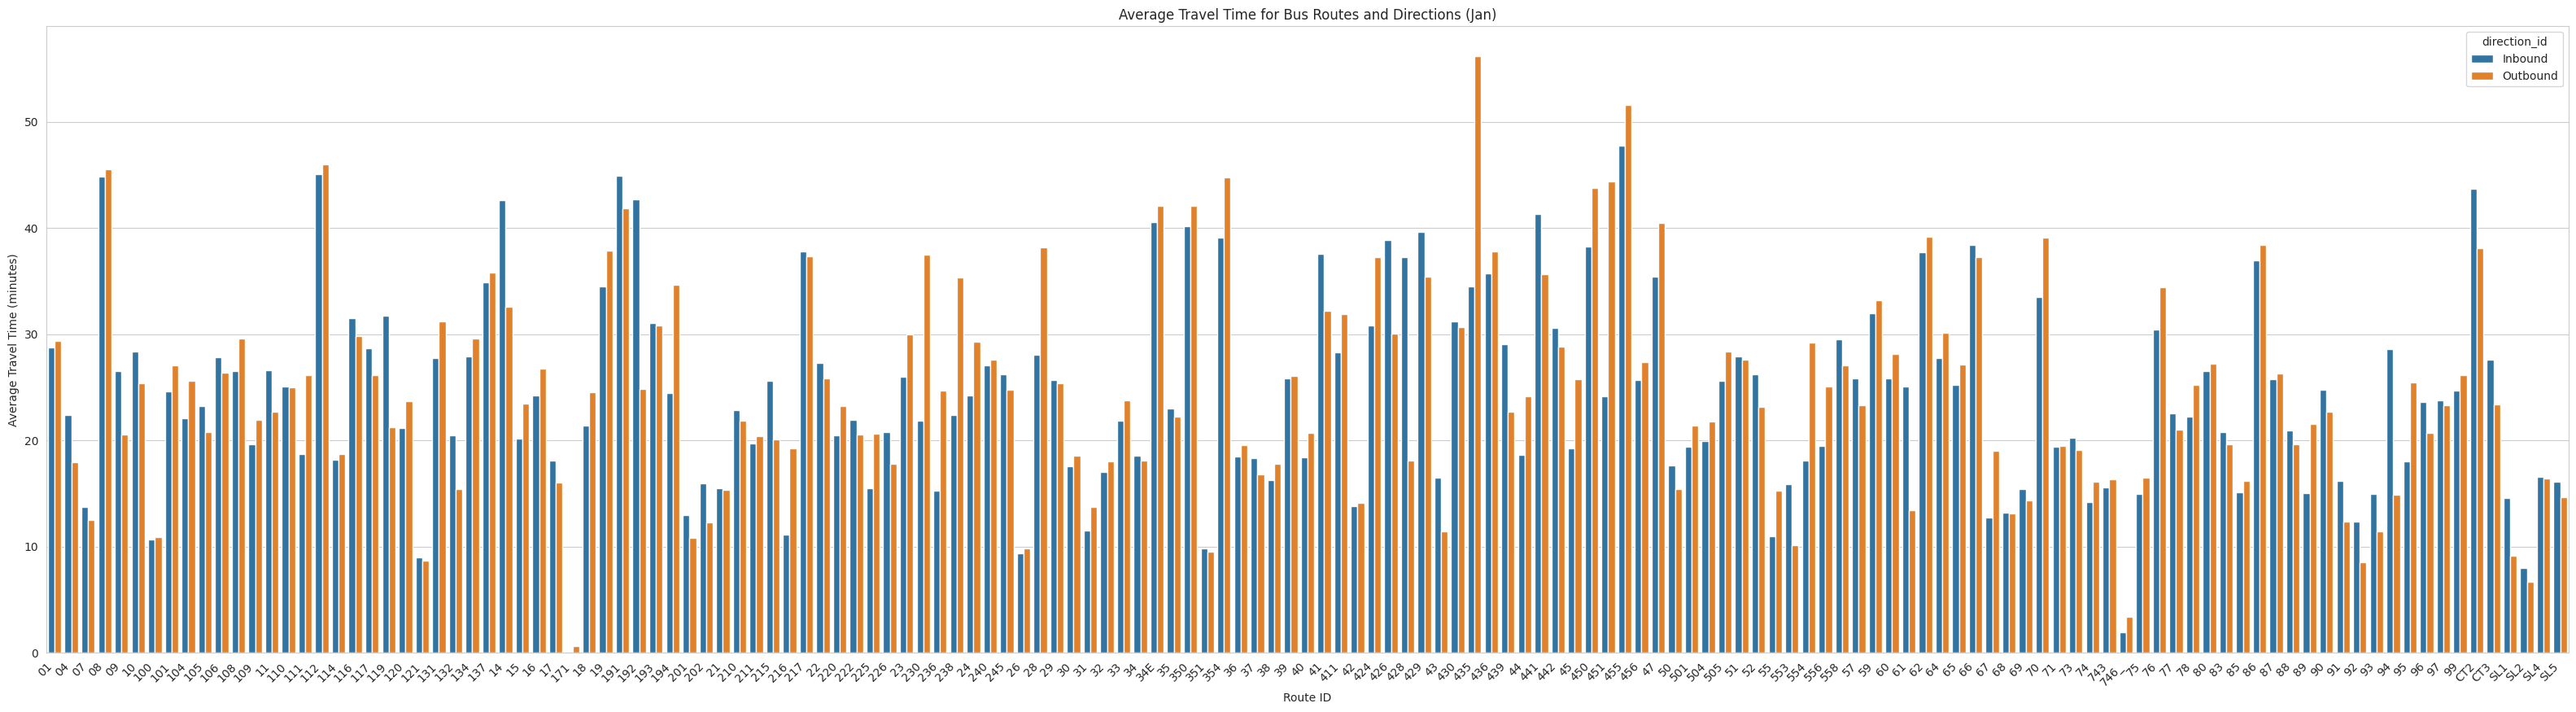

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a grouped bar plot
plt.figure(figsize=(40, 10))
bar_plot = sns.barplot(x='route_id', y='average_time_diff', hue='direction_id', data=jan_avg, ci=None)

# Customize the plot
bar_plot.set_title('Average Travel Time for Bus Routes and Directions (Jan)')
bar_plot.set_xlabel('Route ID')
bar_plot.set_ylabel('Average Travel Time (minutes)')
bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=45, horizontalalignment='right')

# Show the plot
plt.show()


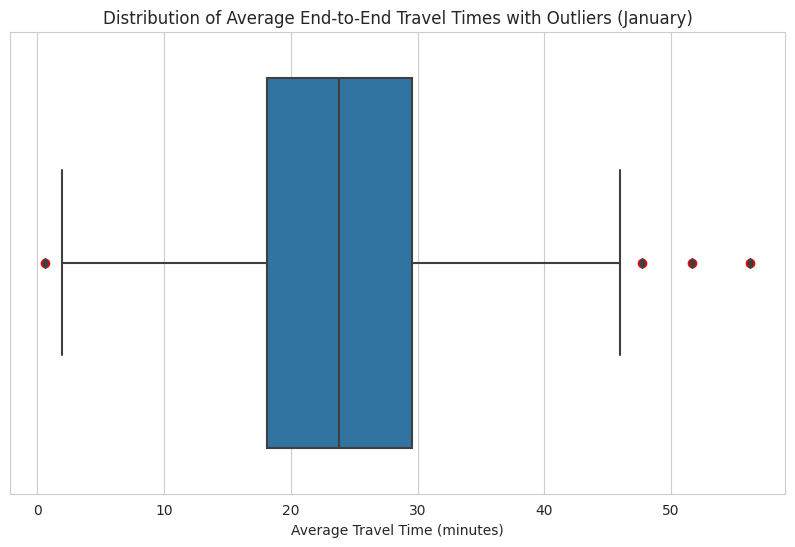

In [38]:

def detect_outliers_iqr(data, column_name, multiplier=1.5):

    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = np.percentile(data[column_name], 25)
    Q3 = np.percentile(data[column_name], 75)

    # Calculate the IQR (Interquartile Range)
    IQR = Q3 - Q1

    # Define the fences
    lower_fence = Q1 - multiplier * IQR
    upper_fence = Q3 + multiplier * IQR

    # Find outliers
    outliers = data[(data[column_name] < lower_fence) | (data[column_name] > upper_fence)]
    return outliers

def box_plot_graph_out(average_times, outliers, month):
  plt.figure(figsize=(10, 6))
  sns.boxplot(x='average_time_diff', data=average_times)
  plt.scatter(outliers['average_time_diff'], [0] * len(outliers), color='red')
  plt.title('Distribution of Average End-to-End Travel Times with Outliers ('+ month + ')')
  plt.xlabel('Average Travel Time (minutes)')
  plt.show()


jan_out = detect_outliers_iqr(jan_avg, 'average_time_diff')

box_plot_graph_out(jan_avg, jan_out, "January")



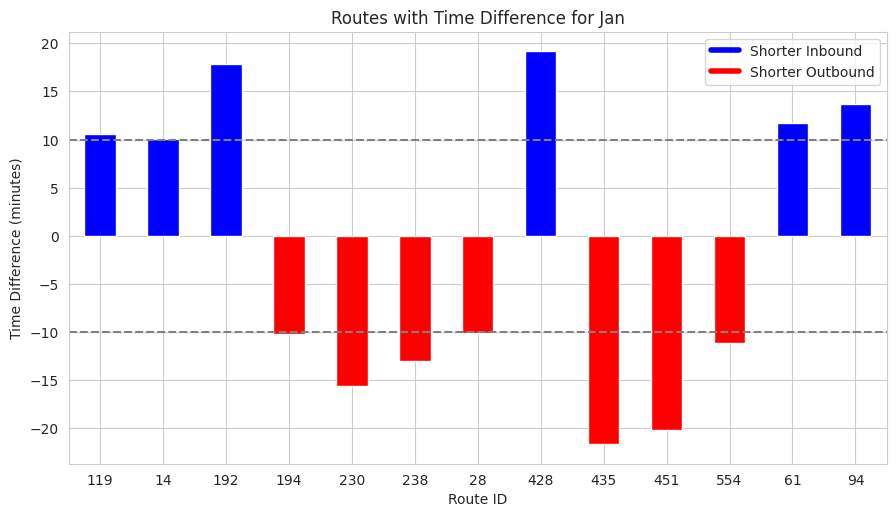

In [39]:
# using averages to find the differences in inbound and outbound
comparing_bounds_data = [jan_avg]

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Creating 3x2 grid to plot for each month (Jan-June)
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
fig.tight_layout(pad=5.0)

# Each Dataframe placed in idx, graphs side by side.
for idx, df in enumerate(comparing_bounds_data):
    ax = axes

    # Pivot the dataframe to get direction as columns
    diffs = df.pivot(index='route_id', columns='direction_id', values='average_time_diff')

    # calculate the time difference between Inbound and Outbound to filter
    # We are accounting for greater than 10 minutes difference as something to note
    diffs['time_difference'] = diffs['Inbound'] - diffs['Outbound']
    filtered_diffs = diffs[diffs['time_difference'].abs() > 10]['time_difference']
    # Colors depend on which is shorter: Inbound or Outbound
    color_map = filtered_diffs.apply(lambda x: 'blue' if x > 0 else 'red')
    filtered_diffs.plot(kind='bar', ax=ax, color=color_map)


    # Lines on the 10 minutes marks
    ax.axhline(y=10, color='gray', linestyle='--')
    ax.axhline(y=-10, color='gray', linestyle='--')

    # Titling and labeling
    ax.set_title(f"Routes with Time Difference for {months[idx]}")
    ax.set_ylabel('Time Difference (minutes)')
    ax.set_xlabel('Route ID')

    # Determine if we have shorter inbound or shorter outbound times to adjust the legend appropriately
    has_shorter_inbound = any(color_map == 'blue')
    has_shorter_outbound = any(color_map == 'red')

    # Create custom legend based on the data
    legend_labels = []
    legend_colors = []

    if has_shorter_inbound:
        legend_labels.append('Shorter Inbound')
        legend_colors.append('blue')

    if has_shorter_outbound:
        legend_labels.append('Shorter Outbound')
        legend_colors.append('red')

    # Create bars for legend

    legend_handles = [Line2D([0], [0], color=color, lw=4) for color in legend_colors]

    # Attach the legend to the plot
    ax.legend(legend_handles, legend_labels)


    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(filtered_diffs.index, rotation=0)

plt.show()
